# <center>South African Language Identification</center>


© Explore Data Science Academy

## <center>Introduction</center>

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

The key deliverables in this project include:
* Developing a model that can identify South African languages based on the dataset provided.
* Provide a clear explanation about the performance of the model.
* Analyse the data and generate valuable insights to inform model tuning.
* Provide recommendations based on the performance of classification models applied to the dataset. 

###  Table of Contents


* 1. [Importing Packages](#Importing_Packages)

* 2. [Loading Data](#Loading_Data)

* 3. [Data Preproprocessing](#Data_Preprocessing)
    
* 4. [Feature Engineering](#Feature_Engineering)
    * 4.1. [Tfid Vectorizer](#tfidvectorizer)
    * 4.2. [Count Vectorizer](#countvectorizer)
    * 4.3. [Prepare Data for Training](#preparedatafortraining)
    
* 5. [Modelling](#Modelling)
    * 5.1. [Build Classification Models](#buildclassificationmodels)
    * 5.2. [Logistic Regression](#logisticregression)
    * 5.3. [Passive Aggressive Classifier](#passiveaggressiveclassifier)
    * 5.4. [XGBoost Classifier](#xgboostclassifer)
    * 5.5. [Naive Bayes](#naivebayes)
    * 5.6. [Submission](#submission)
    
* 6. [Conclusion](#Conclusion)

 
## 1. Importing Packages <a class="anchor" id="Importing_Packages"></a>

In [2]:
# Libraries for data loading, data manipulation and data visulisation
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

# Libraries for Data Preprocessing and Modelling
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Set Plot Style
sns.set()
import warnings
warnings.filterwarnings('ignore')

/Users/jack/.pyenv/versions/3.10.2/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 2. Loading Data <a class="anchor" id="Loading_Data"></a>

The dataset is an aggregation South African official languages, which total about 11. The dataset contains:
* lang-id: Unique String (Language Abbreviation)
* text: Sample texts in different languages.



In [3]:
df_train = pd.read_csv('data/train_set.csv')
df_test = pd.read_csv('data/test_set.csv')
samplesubmission = pd.read_csv('data/sample_submission.csv')

# Preview Train Data
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


Let us look at the bottom rows of the train data.

In [4]:
df_train.tail()

,lang_id,text
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...
32999,sot,mafapha a mang le ona a lokela ho etsa ditlale...


In [5]:
# Preview Test Data
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


Check the shapes of the train and test dataset

In [6]:
print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape:  (33000, 2)
Test data shape:  (5682, 2)


In [7]:
print('Dataset size:',df_train.shape)
print('Columns are:',df_train.columns)


Dataset size: (33000, 2)
Columns are: Index(['lang_id', 'text'], dtype='object')


Looking at the number of languages and their frequencies in the train dataset.

In [8]:
df_train['lang_id'].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

The frequency of each of the eleven languages in the dataset is balanced. There are 3000 occurences of each language in the train dataset.
It is pertinent to understand in real life it is natural to deal with imbalanced data in most cases. Therefore, the goal shoudld be on reducing imbalance to manageable levels. It will be interesting to assess the performance of the model when dealing with a balanced daa like the train dataset in this project. 
We can develop a bar chart to confirm the view of how each language occures through the train dataset.

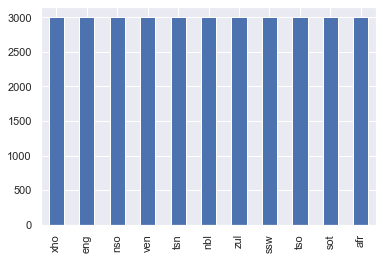

In [9]:
df_train.lang_id.value_counts().plot(kind='bar');

## 3. Data Preprocessing <a class="anchor" id="Data_Preprocessing"></a>


In preparation for modelling, it is important to ensure the dataset is turned into a formate that makes it easy for the model to make sense of the data. Text cleaning is necesary because it ensures that the text data is free of things like punctuation, numerical values and other signs that do not have a direct impact on the performance of the classification model. They are considered noise, which can ultimately affect the accuracy of the model. The key steps in text cleaning include:
* Removal of special characters
* Removing punctuation
* Lowering the caps

All these steps are carried to make it easy for machine learning models to make sense of the data during analysis. 


In [10]:
# Create function to clean the data

def text_cleaning(df, col):
  """ Takes in a string value, returns string devoid of url, punctuation and caps lower"""

  # Handling URLs
  print ('Removing URLs...')
  pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
  subs_url = r'url-web'
  df[col] = df[col].replace(to_replace = pattern_url, value = subs_url, regex = True)

  # Make lower case
  print ('Lowering case...')
  df[col] = df[col].str.lower()

  # Dealing with Punctuation
  print('Removing punctuation...')
  def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])
  df[col] = df[col].apply(remove_punctuation_numbers)
  
  return df


In [11]:
# Create a copy of train and test data 
train_data = df_train.copy()
test_data = df_test.copy()

In [12]:
# Apply Text Preprocessing
train_data = text_cleaning(train_data, 'text')

test_data = text_cleaning(test_data, 'text')

Removing URLs...
Lowering case...
Removing punctuation...
Removing URLs...
Lowering case...
Removing punctuation...


In [13]:
# Preview Cleaned Train Data
train_data.head()

,lang_id,text
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulunatal department of tra...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [14]:
# Preview Cleaned Test Data
test_data.head()

,index,text
0,1,mmasepala fa maemo a a kgethegileng a letlelel...
1,2,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,tshivhumbeo tshi fana na ngano dza vhathu
3,4,kube inja nelikati betingevakala kutsi titsini...
4,5,winste op buitelandse valuta


## 4. Feature Engineering <a class="anchor" id="Feature_Engineering"></a>

### 4.1 Tfid Vectorizer <a class="anchor" id="tfidvectorizer"></a>

[Term Frequency Inverse Document Frequency(TF-IDF)](https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558) is an algorithm that the frequency of word in a document and its rareness across the whole corpus of documents. Term Frequency(tf) is focused on how many times a word appears in a particular document Sklearn tf checks the number of times a term 'x' occurs in a document. 
Inverse Document Frequency(idf) measures how rare or common a term is the entire corpus of documents. A word that is frequent in all the documents analyzed has a normalisation approaching zero or 1 if it is not the case. Sklearn uses the formula:
* idf(t) = log e [ (1+n) / ( 1 + df(t) ) ] + 1 (default i:e smooth_idf = True)

    and

* idf(t) = log e [ n / df(t) ] + 1 (when smooth_idf = False)

The Term Frequency-Inverse Document Frequency(tf-idf) of a document is the product of tf and idf. A higher value indicates the term is more relevant in the document. 


In [15]:
vectorizer = TfidfVectorizer(max_features=1500, max_df=0.8)

The next step is to fit all the words on the vectorizer. 

In [16]:
# Vectorize Train Data
train_data_vec = vectorizer.fit_transform(train_data['text']).toarray()

# Create dataframe for training data
train_new = pd.DataFrame(train_data_vec, columns=vectorizer.get_feature_names())

# Print shape of training dataframe
print('Training Data: ', train_new.shape)

# Vectorize test data
test_data_vec = vectorizer.transform(test_data['text']).toarray()

# New Dataframe for test data
test_new = pd.DataFrame(test_data_vec, columns=vectorizer.get_feature_names())

# Print the shape of test data
print('Test Data: ', test_new.shape)


Training Data:  (33000, 1500)
Test Data:  (5682, 1500)


### 4.2. Count Vectorizer  <a class="anchor" id="countvectorizer"></a>

Count Vectorizer converts words into numbers that show the frequency of the word in the document. The major difference between Count Vectorizer and TFIDVectorizer is that the former focuses on the count frequency of the word in the document while TFID goes ahead to consider how important a word is in the document. 

In [17]:
vect = CountVectorizer(max_df=0.8)

The next step is to prepare some train and test data vectorized using Count Vectorizer.

In [18]:
# Vectorize Train Data
count_train = vectorizer.fit_transform(train_data['text']).toarray()

# Create dataframe for training data
count_train = pd.DataFrame(train_data_vec, columns=vectorizer.get_feature_names())

# Print shape of training dataframe
print('Training Data: ', train_new.shape)

# Vectorize test data
count_test = vectorizer.transform(test_data['text']).toarray()

# New Dataframe for test data
count_test = pd.DataFrame(test_data_vec, columns=vectorizer.get_feature_names())

# Print the shape of test data
print('Test Data: ', test_new.shape)

Training Data:  (33000, 1500)
Test Data:  (5682, 1500)


### 4.3. Prepare Data for Training <a class="anchor" id="preparedatafortraining"></a>

In this section, we define features(X) and target(Y) for training. Label Encoding is used to transform string language identities into numerical values for the model to understand.

In [19]:
X = train_new
y = train_data['lang_id']

Apply label encoding in the next cell to convert them into numerical values. 

In [20]:
label_encoder = LabelEncoder() 
y_label = label_encoder.fit_transform(y)

Splitting Data into train and test for data created using TfidVectorizer

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.1, random_state=0)

Prepare test and train data vectorized using Count Vectorizer for comparative purposes. The target value is the same for both vectorizing methods from scikit-learn library.

In [22]:
X1 = count_train

In [23]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y_label, test_size=0.1, random_state=0)

In [24]:
count_test.head()

,aan,aansoek,abantu,abantwana,abanye,abasebenzi,abe,abo,act,aforika,...,ḓa,ḓi,ḓo,ḓuvha,ḽa,ḽi,ḽo,ṅwaha,ṱhanziela,ṱo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Modelling <a class="anchor" id="Modelling"></a>

The following models will be tried in this section with the hope selecting the best performing model:
* Logistic Regression
* Passive Aggressive Classifier
* XGBoost Classifier
* MultiNomialNB
* GaussianNB
* BernoulliNB

### 5.1. Build Classification Models <a class="anchor" id="buildclassificationmodels"></a>

The modelling process is time intensive and demands a lot of computing power. In this section, I will use a limited number of features to assess the performance of pre-selected models before selecting one model for hyperparameter tuning. 

In [25]:
names = ['Logistic Regression', 'MultiNomial', 
         'Passive', 'Gaussian',  'Bernoulli']

In [26]:
classifiers = [
    LogisticRegression(), 
    MultinomialNB(),
    PassiveAggressiveClassifier(),
    GaussianNB(),
    BernoulliNB()
]

In [27]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='macro')
    recall    = metrics.recall_score(y_train, y_pred, average='macro')
    
    f1        = metrics.f1_score(y_train, y_pred, average='macro')    
    f1_test   = metrics.f1_score(y_test, y_pred_test, average='macro')    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 
                                         'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Fitting MultiNomial model...
... predicting
... scoring
Fitting Passive model...
... predicting
... scoring
Fitting Gaussian model...
... predicting
... scoring
Fitting Bernoulli model...
... predicting
... scoring
... All done!


In [28]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
Passive,0.984747,0.984947,0.984680,0.984636,0.977280,11.965616
Logistic Regression,0.984074,0.983993,0.984004,0.983986,0.982695,31.022240
Bernoulli,0.981852,0.981868,0.981775,0.981749,0.984439,0.592999
MultiNomial,0.979461,0.979377,0.979366,0.979327,0.981940,0.208341
Gaussian,0.964276,0.966294,0.964121,0.963036,0.962900,0.832703


<AxesSubplot:xlabel='Classifier'>

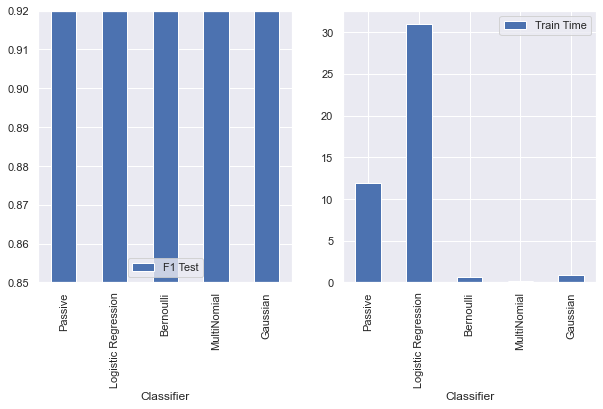

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.85,0.92])
results.plot(y='Train Time', kind='bar', ax=ax[1])

The accuracy of all the five models is above 0.95, which is impressive. The analysis for was done using vectorized data with 1500 features. The best performing model is Passive Aggressive with a score of 0.98. I took time to delve deeper into all the models tested because of the high accuracy values during the test. The key difference among the models tested lies in the time it takes to train the model. 

Logistic Regression registered the highest time followed by Passive Aggressive Classifier. The low running times shown by Naive Bayes algorithms can be attributed to the simplicity in the way they deal with classification problems. The 'naive' assumption of independence among variables given the class one variable is determined means less time is spend on finding the smooth curves separating different classes. 

### 5.2. Logistic Regression <a class="anchor" id="logisticregression"></a>

Logistic Regression is a the process of  determining the probability of an outcome given an input. In this instance, I utilised the Logistic Regression algorithm from Sklearn Linear models. In machine learning, logisic regression algorithm is used in modelling the classification of categorical variables. It is applicable in text analysis that requires the determination of different categories of data based on language, which explains why it is selected for this task. The model is fitted and predicted on the validation data to check accuracy levels. 

In [26]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_pred = log_reg.predict(X_test)
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.99      1.00      1.00       272
           2       0.98      0.98      0.98       312
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       299
           5       0.99      0.99      0.99       320
           6       1.00      1.00      1.00       295
           7       1.00      1.00      1.00       299
           8       1.00      1.00      1.00       306
           9       0.98      0.97      0.98       308
          10       0.95      0.96      0.96       312

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



### 5.3. Passive Aggressive Classifier <a class="anchor" id="logisticregression"></a>

The Passive Aggressive Classifier algorithm is known for its applications in online systems. The algorith reacts passively to correct classification and aggressively towards misclassification, which explains the name Passive Aggressive.  The suitability of the algorithm is derived from the tests performed above and level of performance shown when dealing with 1500 features in the train and validation data. In this section, I fit the model and predict using the split test data with the aim of checking the accuracy on the train data. 

In [27]:
pa_clf = PassiveAggressiveClassifier(max_iter=50, n_jobs=-1)
pa_clf.fit(X_train, y_train)
pa_clf_pred = pa_clf.predict(X_test)
print(classification_report(y_test, pa_clf_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       300
           1       0.99      1.00      1.00       272
           2       0.99      0.96      0.98       312
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       299
           5       0.97      0.99      0.98       320
           6       1.00      1.00      1.00       295
           7       1.00      1.00      1.00       299
           8       1.00      1.00      1.00       306
           9       0.96      0.97      0.96       308
          10       0.96      0.93      0.94       312

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



### 5.4. XGBoost Classifier <a class="anchor" id="xgboostclassifier"></a>

XGBoost is a popular algorithm known for its robust and powerful nature when it comes to machine learning problems. The motivation behind the selection is guided by extensive reading that testifies to the effectives of the XGBClassifier in handling text data. In this section, the model is fitted and predited using validation to check accuracy. 

In [ ]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', verbosity='2', num_class=11)

In [ ]:
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, xgb_pred))

An accuracy of 0.98 when using 1,500 features on the vectorizer.Overfitting is a possibility in this case. It might come clear when tested on the test dataset. The score on the leaderboard gave 0.76, which confirms that model is overfitting on the validation data. 
The biggest challenge with the application of XGBClassifier in this challenge is the demand for time and tuning needed to get a better performance. There are models like Passive Aggressive, Logistic Regression and Naive Bayes that have performed better with less tuning. I would recommend the application of XGBClassifier if one has an intimate understanding of the dataset, time is not a factor and access to adequate computing memory. 


### 5.5. Naive Bayes <a class="anchor" id="naivebayes"></a>

Naive Bayes methods are founded on the principles of Bayes Theorem. The term 'naive' is the because of the assumption of indepence between every pair of features as long as the class of the variable is provided. 
* The Multinomial Naive Bayes Classifier is considered suitable for discrete features classification. It can work well with tf-idf fraction counts in some instances.
* Gaussian Naive Bayes has the ability to update the parameters of the features using partial fit.
* Bernoulli Naive Bayes is also good for discrete features. The key difference with Multinomial is that it works well with binary/boolean features.

In [19]:
NB = MultinomialNB()
GB = GaussianNB()
BN = BernoulliNB()

In [32]:
NB.fit(X_train, y_train)
NB_pred= NB.predict(X_test)
print(classification_report(y_test, NB_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.99      1.00      0.99       272
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       299
           5       1.00      1.00      1.00       320
           6       1.00      1.00      1.00       295
           7       1.00      1.00      1.00       299
           8       1.00      1.00      1.00       306
           9       1.00      1.00      1.00       308
          10       1.00      0.99      0.99       312

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



In [20]:
BN.fit(X_train, y_train)
BN_pred= BN.predict(X_test)
print(classification_report(y_test, BN_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.99      1.00      1.00       272
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       299
           5       1.00      1.00      1.00       320
           6       1.00      1.00      1.00       295
           7       1.00      1.00      1.00       299
           8       1.00      1.00      1.00       306
           9       1.00      1.00      1.00       308
          10       1.00      0.99      1.00       312

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



In [35]:
GB.fit(X_train, y_train)
GB_pred= GB.predict(X_test)
print(classification_report(y_test, GB_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       272
           2       0.99      0.98      0.98       312
           3       0.98      1.00      0.99       277
           4       0.99      0.99      0.99       299
           5       1.00      1.00      1.00       320
           6       1.00      0.99      0.99       295
           7       1.00      1.00      1.00       299
           8       1.00      1.00      1.00       306
           9       0.98      0.99      0.99       308
          10       0.98      0.97      0.98       312

    accuracy                           0.99      3300
   macro avg       0.99      0.99      0.99      3300
weighted avg       0.99      0.99      0.99      3300



Naive Bayes for data vectorized using Count Vectorizer

In [30]:
NB.fit(X_train1, y_train1)
NB_pred_count= NB.predict(X_test1)
print(classification_report(y_test1, NB_pred_count))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.99      1.00      0.99       272
           2       1.00      1.00      1.00       312
           3       1.00      1.00      1.00       277
           4       1.00      1.00      1.00       299
           5       1.00      1.00      1.00       320
           6       1.00      1.00      1.00       295
           7       1.00      1.00      1.00       299
           8       1.00      1.00      1.00       306
           9       1.00      1.00      1.00       308
          10       1.00      0.99      1.00       312

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



The Naive Bayes models generated the following outcomes on the leaderboad:
* Multinomial Naive Bayes : Highest F1 Score with 0.96
* Gaussian Naive Bayes : Second Highest F1 Score of 0.93
* Bernoulli Naive Bayes : Third Highest with F1 Score of 0.89

The outcome for the validation data has the same accuracy as the data vectorized using TfidVectorizer. The score on the leaderboard is exactly the same as the one scored using TfidVectorizer, which suggests in this particular language identification the two vectorizers with minimal tuning have the same effect.

Presenting the model with the unseen data (the test dataset)

In [21]:
sub_pred = BN.predict(test_new)

### 5.6. Submission  <a class="anchor" id="submission"></a>

In [22]:
samplesubmission.head()
submission = pd.DataFrame()
submission['index'] = test_data['index']
submission['lang_id'] = label_encoder.inverse_transform(sub_pred)
submission.to_csv('submission.csv', index=False)

## 6. Conclusion  <a class="anchor" id="Conclusion"></a>

The performance of the all the models tried on the provided dataset are as follows:
* Logistic Regression - F1 Score 0.87
* Passive Aggressive Classifer - F1 Score 0.92
* XGBClassifier - F1 Score 0.75
* Multinomial NB - F1 Score 0.96
* Gaussian NB - F1 Score 0.93
* Bernoulli NB - F1 Score o,89

From the list, the best performing model is Multinomial NB that uses the principles from Bayes Theorem to classify discrete data. It should noted that hyperparameter tuning for Logistic Regression, Passive Aggressive and XGBoost can lead to significant changes as witnessed in other NLP machine learning challenges. In this cases, there was a limit of time and computing power that made it a challenge to delve deep into tuning parameters for all the models. The Naive Bayes algorithms did very well with minimal tuning, which leads to the conclusion that are the best for classification of text data. The application of Naive Bayes in recommender system is a testament of its prowess in text data classifiction. 

The most challenging aspect in all the models is the limit of memory when I tried using all the features from the vectorizer. The performance of MultinomialNB improved steadly with increase in the number of features before hitting a plateau at around 50000 features. Computing power is massively affected hardware that can make it difficult to check the full range of some models. 
